# Load training set

In [0]:
train_set = pd.read_pickle('liar_train.pkl')
train_set

,claim,claimant,label
0,Says the Annies List political group supports ...,dwayne-bohac,0
1,When did the decline of coal start? It started...,scott-surovell,1
2,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,1
3,Health care reform legislation is likely to ma...,blog-posting,0
4,The economic turnaround started at the end of ...,charlie-crist,1
...,...,...,...
2910,Health insurance costs for Floridians are up 3...,Republican Party of Florida,1
6096,"A photograph captures Harriet Tubman as a ""Gun...",,0
10446,"ISIS leader Abu Bakr al Baghdadi was ""released...",Jeanine Pirro,0
5414,"""The board of a nonprofit organization on whic...",Tennessee Republican Party,1


# Load test data

In [0]:
test_set = pd.read_pickle('liar_test.pkl')

# Preparing the text data

In [0]:
import string
import gensim
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 1000

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
train_claims = list()
lines = train_set['claim'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    # convert to lowercase
    tokens = [w.lower() for w in tokens]
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    train_claims.append(words)

print(len(train_claims))

25235


In [0]:
test_claims = list()
lines = test_set['claim'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    # convert to lowercase
    tokens = [w.lower() for w in tokens]
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    test_claims.append(words)

print(len(test_claims))

3111


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
with open('dataset/metadata.json', 'r') as f:
    metadata = json.load(f)

In [0]:
df = pd.DataFrame(metadata)
all_claims = df['claim']

In [0]:
tokenizer = Tokenizer()
# Fit on all claims - ok because no labels
tokenizer.fit_on_texts(all_claims)

In [0]:
# save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 24909 unique tokens.


In [0]:
train_seq = tokenizer.texts_to_sequences(train_claims)
X = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
y = train_set['label'].values
y = to_categorical(np.asarray(y))

In [0]:
print("Shape of training data tensor:", X.shape)
print("Shape of training label tensor:", y.shape)

Shape of training data tensor: (25235, 1000)
Shape of training label tensor: (25235, 3)


In [0]:
test_seq = tokenizer.texts_to_sequences(test_claims)
X_val = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
y_val = test_set['label'].values
y_val = to_categorical(np.asarray(y_val))

In [0]:
print("Shape of validation data tensor:", X_val.shape)
print("Shape of validation label tensor:", y_val.shape)

Shape of validation data tensor: (3111, 1000)
Shape of validation label tensor: (3111, 3)


In [0]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_train, y_train = sm.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
print("Shape of X_train tensor:", X_train.shape)
print("Shape of y_train tensor:", y_train.shape)

print("Shape of X_val tensor:", X_val.shape)
print("Shape of y_val tensor:", y_val.shape)

Shape of X_train tensor: (36903, 1000)
Shape of y_train tensor: (36903, 3)
Shape of X_val tensor: (3111, 1000)
Shape of y_val tensor: (3111, 3)


# Preparing the embedding layer

In [0]:
embeddings_index = {}
with open('reference/glove.6B.300d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

In [0]:
for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers.embeddings import Embedding

In [0]:
embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Training a 1D convnet

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Flatten, LSTM, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adadelta
from matplotlib import pyplot as plt

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [0]:
m1 = Sequential()
m1.add(embedding_layer)
m1.add(Conv1D(128, 5))
m1.add(BatchNormalization())
m1.add(Activation('relu'))
m1.add(MaxPooling1D(5))
m1.add(Dropout(0.5))
m1.add(Conv1D(128, 5))
m1.add(BatchNormalization())
m1.add(Activation('relu'))
m1.add(MaxPooling1D(5))
m1.add(Dropout(0.5))
m1.add(Flatten())
m1.add(Dense(128, activation='relu'))
m1.add(Dense(3, activation='softmax'))

m1.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, nesterov=True),
              metrics=['acc'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
m1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         7473000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          192128    
_________________________________________________________________
batch_normalization_1 (Batch (None, 996, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 996, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)         

In [0]:
h1 = m1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=60)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 36903 samples, validate on 3111 samples
Epoch 1/60
36903/36903 [==============================] - 23s 631us/step - loss: 1.1173 - acc: 0.3551 - val_loss: 1.0846 - val_acc: 0.4764
Epoch 2/60
36903/36903 [==============================] - 19s 528us/step - loss: 1.0745 - acc: 0.4107 - val_loss: 1.1404 - val_acc: 0.2864
Epoch 3/60
36903/36903 [==============================] - 20s 533us/step - loss: 1.0269 - acc: 0.4783 - val_loss: 1.0425 - val_acc: 0.4773
Epoch 4/60
36903/36903 [==============================] - 20s 531us/step - loss: 0.9889 - acc: 0.5133 - val_loss: 1.0070 - val_acc: 0.5198
Epoch 5/60
36903/36903 [==============================] - 20s 535us/step - loss: 0.9631 - acc: 0.5368 - val_loss: 1.0607 - val_acc: 0.4561
Epoch 6/60
36903/36903 [==============================] - 20s 530us/step - loss: 0.9377 - acc: 0.5529 - val_loss: 1.0117 - val_acc: 0.5088
Epoch 7/60
36903/3690

In [0]:
m1.save("models/conv.h5")

In [0]:
# evaluate the model
train_loss, train_acc = m1.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = m1.evaluate(X_val, y_val, verbose=0)

print('Training accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc))

Training accuracy: 0.939, Test accuracy: 0.680


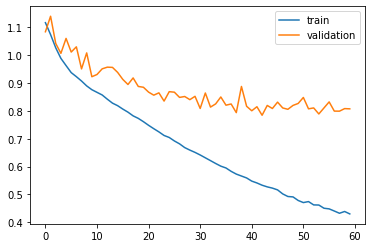

In [0]:
# plot loss
plt.plot(h1.history['loss'], label='train')
plt.plot(h1.history['val_loss'], label='validation')
plt.legend()
plt.show()

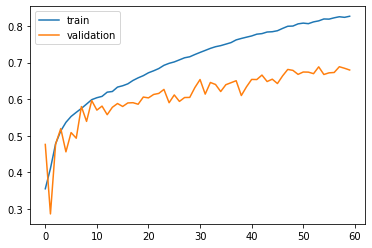

In [0]:
# plot accuracy
plt.plot(h1.history['acc'], label='train')
plt.plot(h1.history['val_acc'], label='validation')
plt.legend()
plt.show()